## 1. Import Library


In [25]:
!pip install mplfinance
import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import mplfinance as mpf
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt


## 2.Load dataset

In [26]:
df = yf.Ticker("BBNI.JK")
df = df.history(period="max")
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-02-10 00:00:00+07:00,4270.0,4310.0,4150.0,4150.0,46856100,0.0,0.0
2025-02-11 00:00:00+07:00,4150.0,4170.0,4050.0,4070.0,52994400,0.0,0.0
2025-02-12 00:00:00+07:00,4130.0,4300.0,4100.0,4300.0,57782300,0.0,0.0
2025-02-13 00:00:00+07:00,4280.0,4300.0,4210.0,4250.0,38173200,0.0,0.0
2025-02-14 00:00:00+07:00,4310.0,4390.0,4300.0,4370.0,61932800,0.0,0.0


In [27]:
del df["Dividends"]
del df["Stock Splits"]

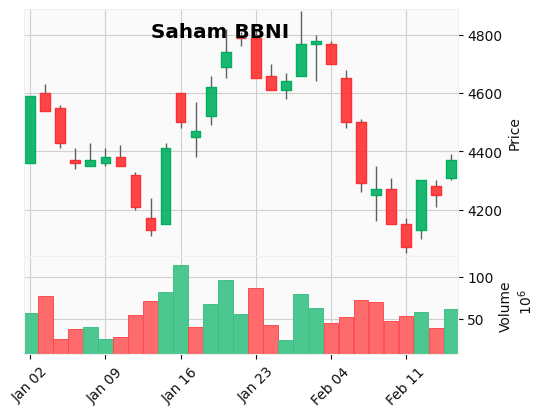

<function matplotlib.pyplot.show(close=None, block=None)>

In [28]:
dfVisual = df.loc["2025-01-01":].copy()

mpf.plot(dfVisual, type='candle', style='yahoo', title='Saham BBNI',
         ylabel='Price', ylabel_lower='Volume', figsize=(5,4),
         volume=True, tight_layout=True)

mpf.show


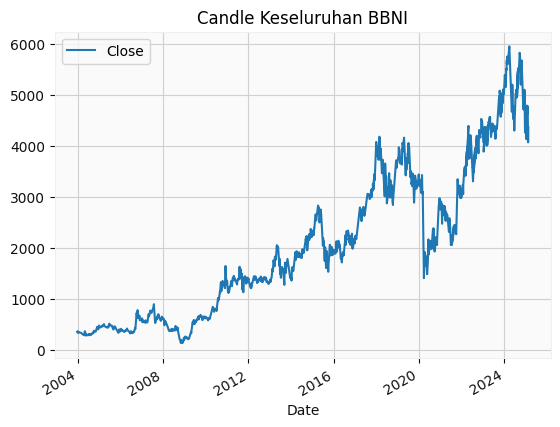

In [29]:
df.plot.line(y="Close", use_index=True)
plt.title("Candle Keseluruhan BBNI")
plt.show()

In [30]:
df = df.loc["2020-01-01":].copy()

In [31]:
# Memuat data
prices = df['Close'].values.reshape(-1, 1)

## 3.Preprocessing data

In [32]:
# Menormalkan data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

# Membagi data menjadi data latih dan data uji
train_size = int(len(scaled_prices) * 0.8)
train_data = scaled_prices[:train_size]
test_data = scaled_prices[train_size:]

In [33]:
# Membuat dataset latih dan uji
def create_dataset(data, lookback):
    X, Y = [], []
    for i in range(len(data) - lookback):
      X.append(data[i:i+lookback])
      Y.append(data[i+lookback])
    return np.array(X), np.array(Y)

lookback = 10 # temporary
X_train, Y_train = create_dataset(train_data, lookback)
test_X, test_Y = create_dataset(test_data, lookback)


## 4. Build model

In [34]:
# Membangun model RNN
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(units=32, input_shape=(lookback, 1)),
    tf.keras.layers.Dense(units=1)
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)             │ (None, 32)                  │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,121 (4.38 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [36]:
# train model
model.fit(X_train, Y_train, epochs=50, batch_size=32)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2978
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0017
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 9.5296e-04
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 7.4363e-04
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.7410e-04
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.1365e-04
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.6878e-04
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.5167e-04
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.0279e-04
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.0789e-04
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5277e-04
Epoch 13/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.1856e-04
Epoch 14/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.5634e-04
Epoch 15/50
31/31 ━━━━━━━━━━━━━━

In [37]:
# Melakukan prediksi
train_preds = model.predict(X_train)
test_preds = model.predict(test_X)

# Menormalkan kembali data
train_preds = scaler.inverse_transform(train_preds)
Y_train = scaler.inverse_transform(Y_train)
test_preds = scaler.inverse_transform(test_preds)
test_Y = scaler.inverse_transform(test_Y)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


## 5. Evaluasi

In [38]:
# Menghitung metrik evaluasi
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(test_Y, test_preds)
mae = mean_absolute_error(test_Y, test_preds)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

Mean Squared Error (MSE): 17852.718328614195
Mean Absolute Error (MAE): 109.8070181197479


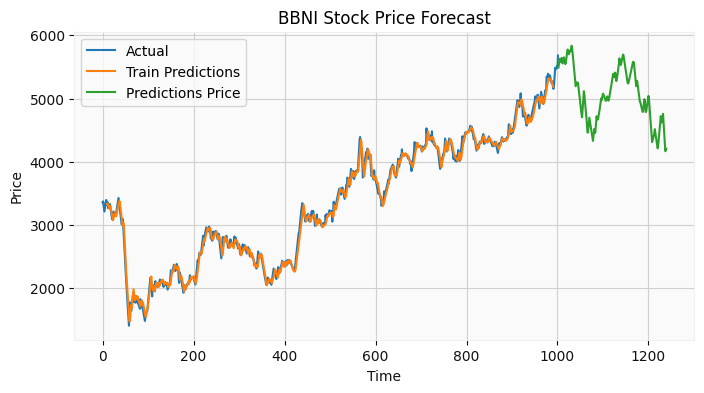

In [39]:
plt.figure(figsize=(8, 4))
plt.plot(prices[:train_size + lookback], label='Actual')
plt.plot(range(lookback, train_size), train_preds, label='Train Predictions')
plt.plot(range(train_size + lookback, len(prices)), test_preds, label='Predictions Price')
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("BBNI Stock Price Forecast")
plt.legend()
plt.show()

In [40]:
# Mengambil periode yang sesuai untuk Test Predictions dan Actual
test_actual = prices[train_size + lookback:]

# Membuat DataFrame untuk perbandingan
comparison_df = pd.DataFrame({'Harga Actual': test_actual.flatten(),
                              'Harga Prediksi': test_preds.flatten()})

comparison_df


,Harga Actual,Harga Prediksi
0,5607.047363,5489.983398
1,5726.346191,5542.227539
2,5726.346191,5590.179199
3,5607.047363,5626.236328
4,5750.205566,5581.522461
...,...,...
233,4150.000000,4323.740723
234,4070.000000,4221.666992
235,4300.000000,4167.095215
236,4250.000000,4179.347656
